## Upwelled water and tracer when the shelf is loooong

Comparison between the base case (alongshore length = 120 km ) and ext2x (alongshore length \approx 240 km ) and ext3x (alongshore length \approx 360 km)

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [21]:
def calc_HCW(Tr,MaskC,rA,hFacC,drF,nzlim=29,yin=227,xin=120,xfin=359,zfin=29,xi=180,yi=50):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
      Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
      MaskC : Land mask for tracer
      nzlim : The nz index under which to look for water properties
      rA    : Area of cell faces at C points (360x360)
      fFacC : Fraction of open cell (90x360x360)
      drF   : Distance between cell faces (90)
      yin   : across-shore index of shelf break
      xin   : alongshore index first cell of downstram box
      xin   : alongshore index of final cell of downstream box
      zfin  : shelf break index + 1 
      xi    : initial profile x index
      yi    : initial profile y index
        
      All dimensions should match.
   
     OUTPUT----------------------------------------------------------------------------------------------------------------
      VolWaterHighConc =  np array with the volume of water with concentration equal or higher than the concentration at Z[nzlim]
      in the initial volume defined by the dimensions of Tr at every time output.
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,Tr[:,:,:,:])

    TrMask=np.ma.array(Tr[:,:,:,:],mask=maskExp)   
    
    trlim1 = TrMask[0,nzlim,yi,xi]
    trlim2 = TrMask[0,nzlim+1,yi,xi] 
  
    #trlim = (trlim1+trlim2)/2  # Average concentration between shelf break and cell below
    trlim=trlim1
    print('tracer limit concentration is: ',trlim)
    
    WaterX = 0
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,xin:xfin], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,xin:xfin],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,xin:xfin]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=2)
    
    TrMassOnShelf = np.sum(np.sum(np.sum(np.ma.array(Tr[:,:zfin,yin:,xin:xfin],
                                                     mask=maskExp[:,:zfin,yin:,xin:xfin])*ShelfVolume_exp,
                                         axis=1),axis=1),axis=1)   
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across, TrMassOnShelf)
 

In [11]:
# Load grid files
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridExt='/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run01/gridGlob.nc'
CanyonGridOutExt = Dataset(CanyonGridExt)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonGridNoCExt='/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run02/gridGlob.nc'
CanyonGridOutNoCExt = Dataset(CanyonGridNoCExt)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
xc_ext = rout.getField(CanyonGridExt, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dxg_ext = rout.getField(CanyonGridExt, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

hFacCNoCExt = rout.getField(CanyonGridNoCExt, 'HFacC')
MaskCNoCExt = rout.getMask(CanyonGridNoCExt, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')
rAExt = rout.getField(CanyonGridExt, 'rA')

z = CanyonStateOut.variables['Z']
x = CanyonStateOut.variables['X']

drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

### Calculate HCW

In [22]:
# Calculate base
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_Can, HCW_Can_along, HCW_Can_across, TrMass_Can = calc_HCW(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                                                              yin=227, xin=0, xfin=359, 
                                                              zfin=29, xi=0, yi=50)
profile_lin = Tr2[0,:,180,50]

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_NoC, HCW_NoC_along, HCW_NoC_across,TrMass_NoC = calc_HCW(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                                                             yin=227, xin=0, xfin=359, 
                                                             zfin=29, xi=180, yi=50)

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [23]:
# Calculate HCW ext 2x
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run01/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_CanExt, HCW_Can_alongExt, HCW_Can_acrossExt, TrMass_CanExt = calc_HCW(Tr2, MaskCNoCExt, rAExt, hFacCNoCExt,
                                                                          drF[:],nzlim=29, 
                                                                          yin=227, xin=0, xfin=539, 
                                                                          zfin=29, xi=180, yi=50)

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run02/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_NoCExt, HCW_NoC_alongExt, HCW_NoC_acrossExt, TrMass_NoCExt = calc_HCW(Tr2, MaskCNoCExt, rAExt, hFacCNoCExt,
                                                                          drF[:],nzlim=29, 
                                                                          yin=227, xin=0, xfin=539, 
                                                                          zfin=29, xi=180, yi=50)

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


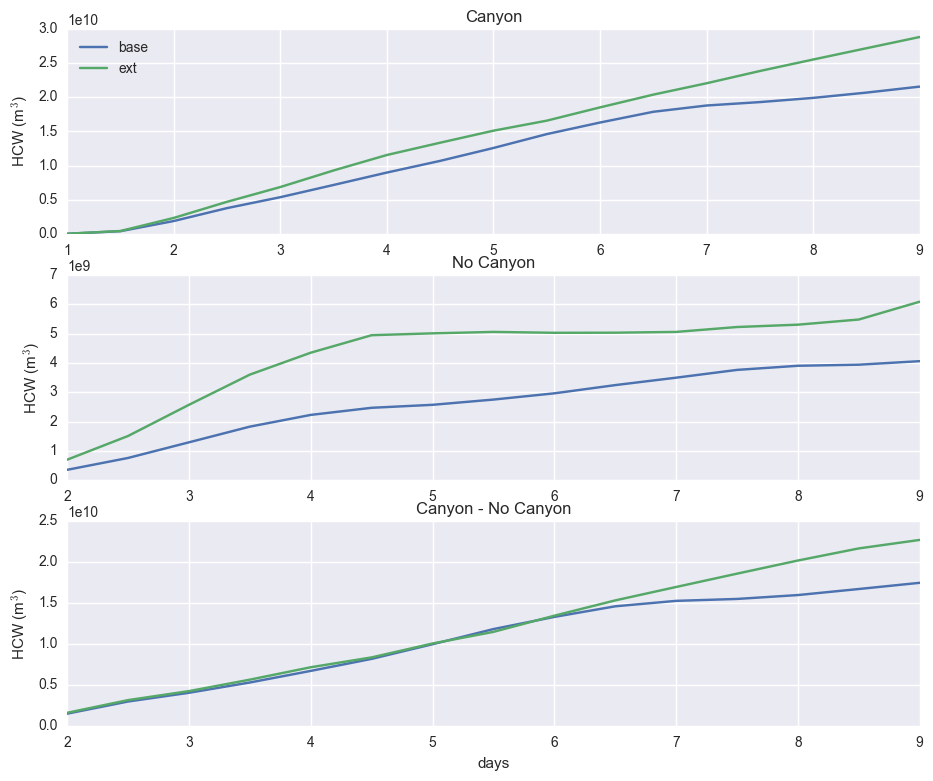

In [6]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(11,9))

ax1.plot(np.arange(19)/2, HCW_Can,label='base')
ax1.plot(np.arange(19)/2, HCW_CanExt,label='ext')
ax1.set_title('Canyon')

ax2.plot(np.arange(19)/2, HCW_NoC)
ax2.plot(np.arange(19)/2, HCW_NoCExt)
ax2.set_title('No Canyon')

ax3.plot(np.arange(19)/2, HCW_Can-HCW_NoC)
ax3.plot(np.arange(19)/2, HCW_CanExt-HCW_NoCExt)
ax3.set_title('Canyon - No Canyon')

ax3.set_xlabel('days')
ax1.set_ylabel('HCW (m$^3$)')
ax2.set_ylabel('HCW (m$^3$)')
ax3.set_ylabel('HCW (m$^3$)')

ax1.legend(loc=0)

### HCW Alongshore 

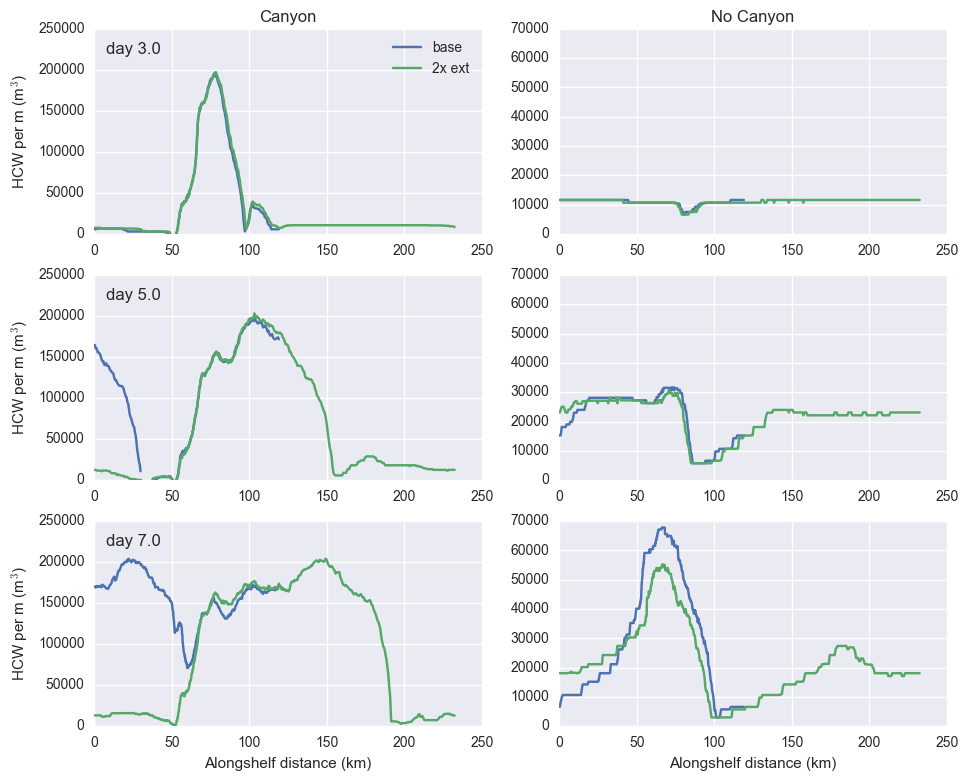

In [7]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')

ii = 0    
for tt in [6,10,14]:
    
    ax[ii,0].plot(xc[0,:-1]/1000, HCW_Can_along[tt,:]/dxg[0,:-1],label='base')
    ax[ii,0].plot(xc_ext[0,:-1]/1000, HCW_Can_alongExt[tt,:]/dxg_ext[0,:-1],label='2x ext')
    
    ax[ii,0].set_ylabel('HCW per m (m$^3$)')
    ax[ii,0].set_ylim(0,250000)
    ax[ii,0].text(0.1, 0.9,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,0].transAxes)
    ax[ii,1].plot(xc[0,:-1]/1000, HCW_NoC_along[tt,:]/dxg[0,:-1],label='base')
    ax[ii,1].plot(xc_ext[0,:-1]/1000, HCW_NoC_alongExt[tt,:]/dxg_ext[0,:-1],label='2X')
    
    ax[ii,1].set_ylim(0,70000)

    ii = ii + 1

ax[2,0].set_xlabel('Alongshelf distance (km)')
ax[2,1].set_xlabel('Alongshelf distance (km)')

ax[0,0].legend(loc=0)

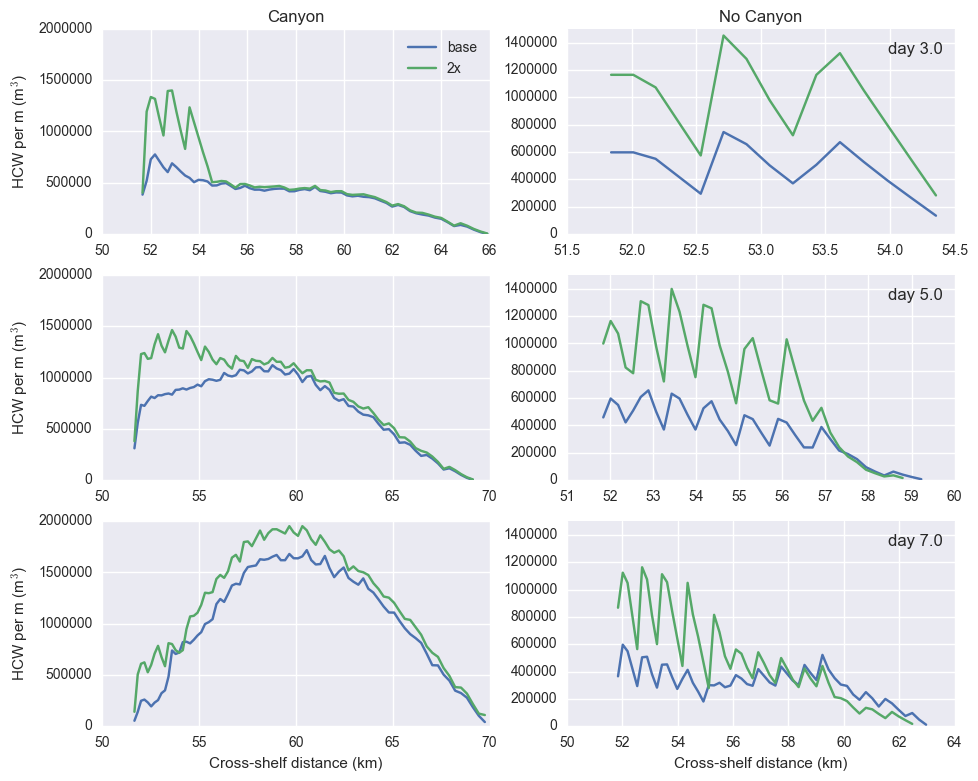

In [8]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')

ii = 0    
for tt in [6,10,14]:
    
    ax[ii,0].plot(yc[227:,0]/1000, HCW_Can_across[tt,:]/dyg[227:,0],label='base')
    ax[ii,0].plot(yc[227:,0]/1000, HCW_Can_acrossExt[tt,:]/dyg[227:,0],label='2x')
   
    ax[ii,0].set_ylabel('HCW per m (m$^3$)')
    ax[ii,0].set_ylim(0,2000000)
    ax[ii,1].text(0.9, 0.9,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)
    ax[ii,1].plot(yc[227:,0]/1000, HCW_NoC_across[tt,:]/dyg[227:,0],label='base')
    ax[ii,1].plot(yc[227:,0]/1000, HCW_NoC_acrossExt[tt,:]/dyg[227:,0],label='2x')
    ax[ii,1].set_ylim(0,1500000)

    ii = ii + 1

ax[2,0].set_xlabel('Cross-shelf distance (km)')
ax[2,1].set_xlabel('Cross-shelf distance (km)')

ax[0,0].legend(loc=0)

### Tracer inventory on shelf

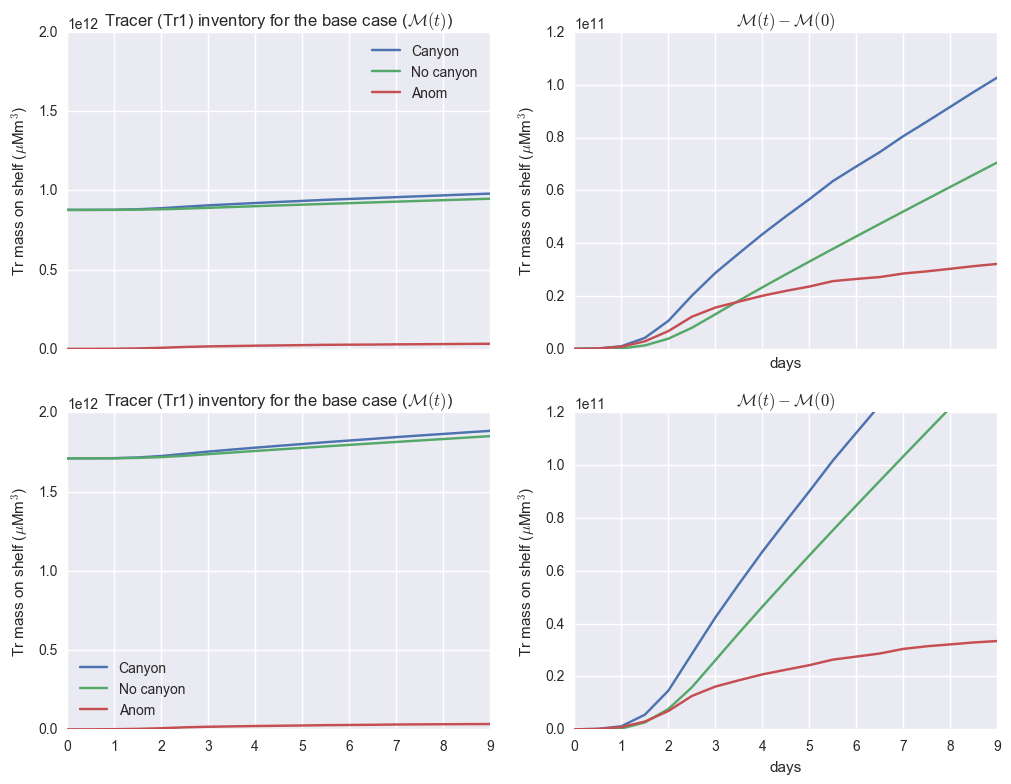

In [34]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,9), sharex=True)

ax1.plot(np.arange(19)/2, TrMass_Can,label='Canyon')
ax1.plot(np.arange(19)/2, TrMass_NoC,label='No canyon')
ax1.plot(np.arange(19)/2, TrMass_Can-TrMass_NoC,label='Anom')
ax1.set_title('Tracer (Tr1) inventory for the base case ($\mathcal{M}(t)$)')
ax1.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')
ax1.set_ylim(0,2E12)

ax2.plot(np.arange(19)/2, TrMass_Can-TrMass_Can[0],label='Canyon')
ax2.plot(np.arange(19)/2, TrMass_NoC-TrMass_NoC[0],label='No canyon')
ax2.plot(np.arange(19)/2, TrMass_Can-TrMass_NoC,label='Anom')
ax2.set_title('$\mathcal{M}(t)-\mathcal{M}(0)$')

ax2.set_xlabel('days')
ax2.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax3.plot(np.arange(19)/2, TrMass_CanExt,label='Canyon')
ax3.plot(np.arange(19)/2, TrMass_NoCExt,label='No canyon')
ax3.plot(np.arange(19)/2, TrMass_CanExt-TrMass_NoCExt,label='Anom')
ax3.set_title('Tracer (Tr1) inventory for the base case ($\mathcal{M}(t)$)')
ax3.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')
ax1.set_ylim(0,2E12)

ax4.plot(np.arange(19)/2, TrMass_CanExt-TrMass_CanExt[0],label='Canyon')
ax4.plot(np.arange(19)/2, TrMass_NoCExt-TrMass_NoCExt[0],label='No canyon')
ax4.plot(np.arange(19)/2, TrMass_CanExt-TrMass_NoCExt,label='Anom')
ax4.set_title('$\mathcal{M}(t)-\mathcal{M}(0)$')
ax4.set_ylim(0,1.2E11)
ax4.set_xlabel('days')
ax4.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax3.legend(loc=0)
ax1.legend(loc=0)